# Code d'utilisation de Florence2 pour extraire des photos depuis des numérisations de pellicules argentiques 🎞️

Ce notebook consigne la suite de test que nous avons effectué afin d'essayer d'automatiser le découpage des pellicules d'Henrot numérisées avec Florence2.

Le notebook passe en revue plusieurs tâches disponibles sur Florence2 afin d'essayer d'obtenir un découpage pertinent des pellicules. 
Nous nous sommes servis du notebook de Microsoft : https://huggingface.co/microsoft/Florence-2-large/blob/main/sample_inference.ipynb pour la définition des tâches.
Et du travail de Marion Charpier sur le LIMC dans le cadre du Hackathon PictorIA à la BNF des 19 et 20 décembre 2024, pour la logique d'organisation et de récupération des données générées en vue de l'industrialisation.

Le notebook est en 3 étapes, il opère d'abord une détection par vocabulaire ouvert et affiche le résultat. Puis, il fait une détection OCR et affiche les résultats et bounding box. Enfin, il fait de la détection d'objets et de segments, il process et organise les sorties pour l'industrialisation, prépare les visualisations puis exécute le tout. 

La conclusion de cette série de test est que pour obtenir des résultats fiables et industrialisables pour le découpage de pellicules Florence2 n'est pas très adapté, et nous allons nous tourner vers une démarche d'apprentissage supervisé en utilisant YOLO et LabelStudio afin d'entraîner un modèle à reconnaître les photos individuelles sur les pellicules afin de les extraires automatiquement grâce à leur coordonnées (bounding box).

# Environnement 🌐

## Import des librairies 📖

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import requests
import hashlib
import random
import utils
import torch
import copy
import math
import sys
import ast
import re

%matplotlib inline

/home/tayib/.conda/envs/FlorenceGPU/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chargement du modèle, détection de matériel et software 🧑‍💻

Depuis la dernière mise de *transformers* Florence2 rencontre des problèmes si on ne force pas la version 4.49.0.

In [2]:
# Installation et vérification de l'installation de *transformers*
try:
    import transformers
    current_version = transformers.__version__
except ImportError:
    current_version = None

required_version = "4.49.0"

if current_version != required_version:
    print(f"⚠️ Version actuelle de transformers : {current_version}, installation de {required_version}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", f"transformers=={required_version}"])
    # Redémarrage nécessaire après upgrade
    print("✅ Installation terminée. Redémarre le kernel puis relance cette cellule.")
else:
    print(f"✅ Bonne version détectée : {current_version}")

    

# Chargement de Florence2 si et seulement si nous avons la bonne version de *transformers*

if current_version == required_version:
    import torch
    from transformers import AutoModelForCausalLM, AutoProcessor

# Choix du device et du dtype
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch_dtype = torch.float16 if device == "cuda" else torch.float32

    print(f"🔍 Détection du matériel...")
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        print(f"→ GPU détecté : {gpu_name}")
    else:
        print("→ Pas de GPU, utilisation du CPU")

    print(f"→ Type de tenseurs utilisé : {torch_dtype}")
    
# Choix du modèle 
    
    model_id = "microsoft/Florence-2-large"
    print(f"🚀 Chargement du modèle {model_id} ...")

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch_dtype,
        trust_remote_code=True,
        attn_implementation="eager" # paramètre plus sûr, évite les erreurs de Flash Attention et les problèmes de chargement si le GPU est indisponible.
    ).to(device)

    processor = AutoProcessor.from_pretrained(
        model_id,
        trust_remote_code=True
    )

    print(f"✅ Modèle '{model_id}' et processor chargés avec succès sur {device.upper()} !")

✅ Bonne version détectée : 4.49.0
🔍 Détection du matériel...
→ GPU détecté : NVIDIA GeForce GTX 1080 Ti
→ Type de tenseurs utilisé : torch.float16
🚀 Chargement du modèle microsoft/Florence-2-large ...
✅ Modèle 'microsoft/Florence-2-large' et processor chargés avec succès sur CUDA !


# Fonction principale 🤖

Nous avons repris la fonction de base du notebook de Florence2

In [3]:
def run_example(task_prompt, path, text_input=None):
    
    """
    Exécute une tâche Florence2 (ex. détection, OCR, segmentation) sur une image donnée.

    Args:
        task_prompt (str):
            Type de tâche à exécuter (doit correspondre à une clé supportée par Florence2, 
            par ex. OPEN_VOCAB_DETECTION, REFERRING_EXPRESSION_SEGMENTATION, etc.).
        path (str):
            Chemin vers l'image à analyser.
        text_input (str, optional):
            Texte optionnel qui précise ou enrichit le prompt de la tâche.
            Par défaut None.

    Returns:
        dict | list | str:
            Résultat de la génération post-traité par le processor 
            (format dépend de la tâche demandée).
    """
   
    image = Image.open(path).convert("RGB")  # Ouvre l'image.
    prompt = task_prompt if text_input is None else f"{task_prompt} {text_input}" # Définis la manière dont la fonction récupère le prompt de la tâche à accomplir.
    
    
    inputs = processor(text=prompt, images=image, return_tensors="pt") # Utilise le processor déjà chargé globalement.
    
    
    inputs["pixel_values"] = inputs["pixel_values"].to(torch_dtype) # Convertir les tenseurs au bon dtype (même que le modèle) pour éviter les problèmes entre les tenseurs 16 et 32.
    inputs["input_ids"] = inputs["input_ids"].to(device)  # Les input_ids restent en long/int.

    with torch.no_grad(): # Évite le calcul des gradients inutiles
        generated_ids = model.generate(
            input_ids=inputs["input_ids"].to(device),
            pixel_values=inputs["pixel_values"].to(device),
            max_new_tokens=512,
            early_stopping=True,
            do_sample=False,
            num_beams=3,
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0] # Transforme en texte les ID de tokens et skip les tokens spéciaux  

        print("=== Generated text ===")
        print(generated_text)
        print("======================")

        parsed_answer = processor.post_process_generation( #Permet de transformer en dict, list ou str le résultat 
            generated_text,
            task=task_prompt,
            image_size=(image.width, image.height),
        )
    return parsed_answer

## Lien vers l'image de test 🖼️

Image test : https://www.gettyimages.fr/photos/pellicule-photo 

In [4]:
img_path = "/mnt/HOME/tayib/notebooks/Florence/color-negative-35mm-film-stripes-on-a-white-background.png" # Lien absolu vers l'image

# Début des tests 🧪

## Vocabulaire ouvert 📒

=== Generated text ===
</s><s><s><s>OPEN_VOCAB_DETECTION> borderless photograph<loc_0><loc_0><loc_999><loc_999></s>


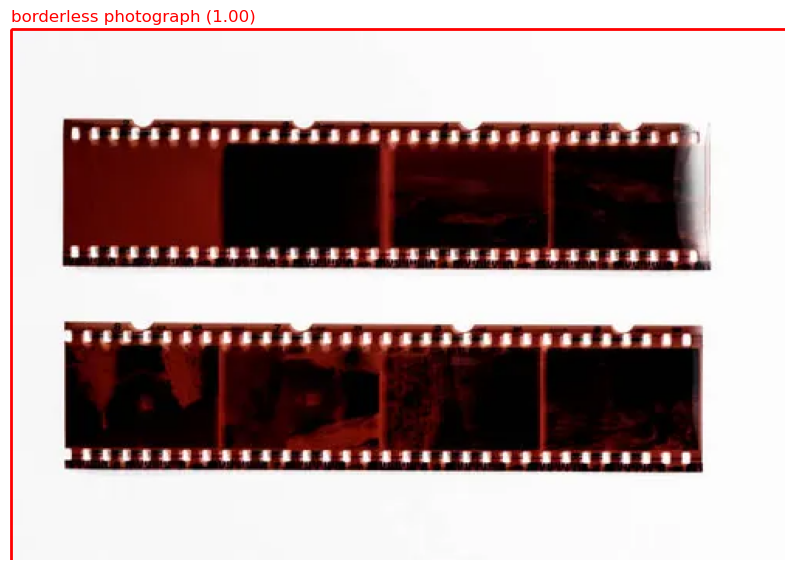

In [5]:
task_prompt = utils.TaskType.OPEN_VOCAB_DETECTION  # On va chercher dans le utils.py la tâche de Florence2 qu'on définit comme étant le task_prompt
results = run_example(task_prompt, img_path, text_input="borderless photograph") # On appelle la fonction avec le prompt le path de l'image et l'input de la tâche, ici du texte.
image = Image.open(img_path) # On ouvre l'image
bbox_results  = utils.convert_to_od_format(results[utils.TaskType.OPEN_VOCAB_DETECTION]) # On appelle la fonction de utils.py qui nous permet de faire la visualisation de bboxs.
utils.plot_bbox(bbox_results, image) # Visualisation

## OCR Processing 🪶

In [6]:
# Tâche OCR simple
task_prompt = '<OCR>'
run_example(task_prompt, img_path)

=== Generated text ===
</s><s><s><s>......
</s>


{'<OCR>': '......\n'}

In [7]:
# Tâche OCR avec région
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt, img_path)
print(results)
# Mise en forme des résultats de l'OCR avec région pour être réutilisable en quad_boxes
#{'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

=== Generated text ===
</s><s><s><s>-<loc_70><loc_402><loc_95><loc_402><loc_95><loc_437><loc_70><loc_437></s>
{'<OCR_WITH_REGION>': {'quad_boxes': [[35.25, 138.0574951171875, 47.75, 138.0574951171875, 47.75, 150.0625, 35.25, 150.0625]], 'labels': ['</s>-']}}


In [8]:
def draw_ocr_bboxes(image, prediction, scale=1): #On définit la fonction pour visualiser les résultats
    
    """
    Dessine les boîtes de délimitation OCR (quad_boxes) et leurs labels sur une image.

    Args:
        image (PIL.Image.Image):
            Image sur laquelle tracer les résultats OCR.
        prediction (dict):
            Résultats de l'OCR contenant au moins les clés 'quad_boxes' (list de coordonnées) 
            et 'labels' (list de textes associés).
        scale (float, optional):
            Facteur d’échelle appliqué aux coordonnées des boîtes. 
            Par défaut 1 (pas de redimensionnement).

    Returns:
        None
            La fonction affiche l'image modifiée mais ne renvoie aucune valeur.
    """
    draw = ImageDraw.Draw(image) # De la librairie PIL on utilise la fonction Draw
    bboxes, labels = prediction['quad_boxes'], prediction['labels'] # Pour faire les visualisations on récupère les labels générés et les quad_boxes pour faire les bboxs
    for box, label in zip(bboxes, labels): # On itère sur la liste des boîtes bboxes et sur la liste de labels, doivent toujours être de même longueur. 
        color = random.choice(colormap) # Pour la visualisation on choisit une couleur random
        new_box = (np.array(box) * scale).tolist() # Pour créer les visualisations on transforme la liste de quad_boxes en ndarray pour multiplier les éléments par scale et obtenir une liste de float pour dessiner les bboxes (on retransforme en liste avec .tolist pour Pillow qui n'accepte pas les ndarray)
        draw.polygon(new_box, width=3, outline=color) # Dessine le polygone avec les points qui sont contenus dans new_box, donc la liste de float.
        draw.text((new_box[0]+8, new_box[1]+2), # Écrit le texte contenu dans label, un peu à côté de la box générée, l'align et le mets de la même couleur que celle random choisie pour la bbox.
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image) # Affiche l'image avec les boîtes dessinées.

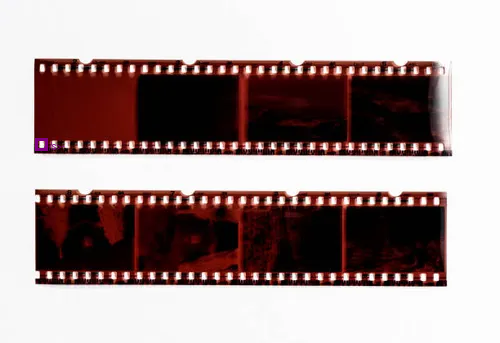

In [9]:
colormap = ["red", "blue", "green", "orange", "purple", "cyan", "magenta"] # Définit les couleurs dans lesquels vont être piochés de manière random la couleur de la bbox
output_image = copy.deepcopy(image) # Créer une copie complète de l'image pour ne pas modifier l'originale
w, h = output_image.size # Récupère la largeur et la hauteur de l'image en pixel
scale = 1.0 # Définit le facteur d'échelle, 1 = pas de ca 
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'], scale=scale) # On prend le résultat de l'OCR et on appelle la fonction de visualisation pour afficher l'image et le résultat du processus.

## Region and object detection processing 🪔

In [10]:
# Liste des tâches de détection à traiter
tasks_img_detection = [ # On définit la liste des tâches qu'on veut faire avec les régions et les objets qui se trouvent dans utils.
    utils.TaskType.OBJECT_DETECTION, # Détection des objets présents sur l'image.
    utils.TaskType.REGION_PROPOSAL, # Proposition de zones d'intérêts.
    utils.TaskType.REGION_TO_SEGMENT, # Segmentation de certaines régions.
    utils.TaskType.REFERRING_EXPRESSION_SEGMENTATION, # Segmentation basée sur un texte descriptif.
]
# Dictionnaire pour stocker les résultats de chaque tâche
results_by_task = {}

for task in tasks_img_detection: # On fait une boucle, pour chaque tâche listée on exécutre du code (en l'occurence ce sera la fonction run_example).
    if task == utils.TaskType.REFERRING_EXPRESSION_SEGMENTATION: # On vérifie si c'est cette tâche en particulier.
        
        results_img_detection = run_example(task, img_path, text_input="unique photograph") # Si c'est le cas, il faut fournir un text_input pour cette tâche spécifique.
    else:
        results_img_detection = run_example(task, img_path) # Si c'est l'une des autres tâches juste run la fonction normale.
    
    results_by_task[task] = results_img_detection # On ajoute le résultat de la tâche courante au dictionnaire results_by_task.
    print(f"{task}: {results_img_detection}") # Affichage du type de tâche et du résultat correspondant. 

=== Generated text ===
</s><s><s><s>book<loc_67><loc_171><loc_903><loc_455></s>
<OD>: {'<OD>': {'bboxes': [[33.75, 58.82449722290039, 451.75, 156.2364959716797]], 'labels': ['book']}}
=== Generated text ===
</s><s><s><s><loc_68><loc_170><loc_903><loc_455><loc_69><loc_552><loc_894><loc_835></s>
<REGION_PROPOSAL>: {'<REGION_PROPOSAL>': {'bboxes': [[34.25, 58.48149871826172, 451.75, 156.2364959716797], [34.75, 189.5074920654297, 447.25, 286.5765075683594]], 'labels': ['', '']}}
=== Generated text ===
</s><s><s><s>REGION_TO_SEGMENT><poly><loc_72><loc_787><loc_892><loc_790><loc_892><loc_831><loc_72><loc_828></poly></s>
<REGION_TO_SEGMENT>: {'<REGION_TO_SEGMENT>': 'REGION_TO_SEGMENT><poly><loc_72><loc_787><loc_892><loc_790><loc_892><loc_831><loc_72><loc_828></poly>'}
=== Generated text ===
</s><s><s><s><loc_70><loc_172><loc_156><loc_172><loc_163><loc_184><loc_167><loc_187><loc_173><loc_187><loc_177><loc_184><loc_186><loc_172><loc_364><loc_172><loc_372><loc_184><loc_375><loc_187><loc_384><loc

### Organisation des données pour l'OBJECT_DETECTION 📋

In [11]:
def process_object_detection(results): # Attend un argument "results" sous forme de dict.
    
    """
    Transforme les résultats de détection d'objet en dictionnaire structuré.

    Args:
        results (dict): dictionnaire renvoyé par le modèle, contenant la clé '<OD>'.

    Returns:
        dict: dictionnaire avec chaque boîte détectée et son label.
    """
    object_detection_data = {} # Création d'un dictionnaire vide pour accueillir les données de l'OBJECT_DETECTION.

    if '<OD>' in results: # Vérifie si la clef 'OD' existe sinon on retourne un dictionnaire vide.
        bboxes = results['<OD>'].get('bboxes', []) # Récupère la liste des bounding boxes.
        labels = results['<OD>'].get('labels', []) # récupère la liste des labels correspondants aux boîtes.

        for i, (bbox, label) in enumerate(zip(bboxes, labels)): # On parcoure simultanément les deux listes, avec zip, et on enumère. 
            object_detection_data[f'Box_{i + 1}'] = { # Pour chaque paire bbox et label on créer une entrée dans object_detection_data 
                'label': label,                 # dont la clef va être Box_1, Box_2, ... 
                'coordinates': bbox             # La valeur est un petit dictionnaire contenant le label, et les coordinates.
            }

    # Affichage optionnel
    print("Données OBJECT_DETECTION (chaque box dans un dictionnaire séparé) :")
    for key, value in object_detection_data.items(): # Boucle sur les paires clé/valeur du dictionnaire construit pour afficher chaque boîte.
        print(f"{key}: {value}")

    return object_detection_data # Renvoie le dictionnaire final structuré.

### Organisation des données pour REGION_PROPOSAL

In [12]:
def process_region_proposal_results(results):

    """
    Transforme les résultats de la tâche REGION_PROPOSAL en dictionnaire structuré.

    Args:
        results (dict): dictionnaire renvoyé par le modèle, contenant 
            la clé '<REGION_PROPOSAL>' avec les boîtes et labels proposés.

    Returns:
        dict: dictionnaire contenant les régions proposées, 
            avec pour chaque boîte un identifiant unique ("Box_1", "Box_2", ...),
            ses coordonnées et son label.
    """
    
    region_proposal_data = {} # On initialise un dictionnaire vide qui servira à stocker toutes les régions proposées, structurées proprement.
    
    if '<REGION_PROPOSAL>' in results:
        bboxes = results['<REGION_PROPOSAL>']['bboxes'] # On extrait depuis results la liste de coordonées des boîtes proposées.
        labels = results['<REGION_PROPOSAL>']['labels'] # Et la liste des labels associés.
        
        for i, (bbox, label) in enumerate(zip(bboxes, labels)): # On parcourt les 2 simultanément.
            region_proposal_data[f'Box_{i + 1}'] = {
                'coordinates': bbox,
                'label': label
            }
    
    print("Données REGION_PROPOSAL (chaque box dans un dictionnaire séparé) :") # On parcourt toutes les entrées du dictionnaire et les affiche proprement.
    for key, value in region_proposal_data.items():
        print(f"{key}: {value}")
    
    return region_proposal_data

### Organisation des données pour REGION_TO_SEGMENT

In [13]:
def process_region_to_segment_results(results, image_size):

    """
    Transforme les résultats de la tâche REGION_TO_SEGMENT en dictionnaire structuré.

    Args:
        results (dict):
            Dictionnaire renvoyé par le modèle, contenant la clé '<REGION_TO_SEGMENT>' 
            sous forme de texte avec des balises <poly> et <loc_x><loc_y>.
        image_size (tuple):
            Dimensions de l'image originale sous forme (largeur, hauteur), 
            utilisées pour convertir les coordonnées normalisées (0–1000) en pixels.

    Returns:
        dict:
            Dictionnaire contenant les polygones extraits, avec un identifiant unique 
            ("Poly_1", "Poly_2", ...), leurs coordonnées en pixels et un label.
    """
    
    region_to_segment_data = {} # On initialise un dictionnaire vide qui contiendra les polygones segmentés.
    
    if '<REGION_TO_SEGMENT>' in results:
        raw_text = results['<REGION_TO_SEGMENT>'] # On récupère la valeur brute correspondant à cette clef.
        # Exemple de raw_text : "REGION_TO_SEGMENT<poly><loc_543><loc_221>...</poly>"
        
        # Extraire les polygones de la chaîne
        polygons = [] # Prépare une liste vide de polygone
        
        # On suppose que le texte contient des balises <poly> avec des <loc_x><loc_y>
        poly_pattern = r'<poly>(.*?)</poly>' # Qu'on récupère via une RegEx.
        matches = re.findall(poly_pattern, raw_text) # On liste de toutes les correspondances trouvées.
        
        for match in matches:
            # Extraire toutes les paires de coordonnées normalisées
            coords_normalized = re.findall(r'<loc_(\d+)><loc_(\d+)>', match) # Liste de tuples de chaînes de chiffres
            # Pour chaque polygone trouvé, on cherche toutes les paires <loc_x><loc_y>.
            # Convertir les coordonnées normalisées en pixels
            coords_pixels = []
            for x_norm, y_norm in coords_normalized:
                x = int(x_norm) * image_size[0] / 1000
                y = int(y_norm) * image_size[1] / 1000
                coords_pixels.append((x, y)) # Stocke les coordonnées converties dans coords_pixels.
            polygons.append(coords_pixels) # Ajoute le polygone converti à la liste polygons.
        
        # Stocker dans le dictionnaire
        for i, poly in enumerate(polygons): # On parcourt la liste des polygones trouvés.
            region_to_segment_data[f'Poly_{i + 1}'] = {
                'coordinates': poly,
                'label': 'segment'  # Vous pouvez ajuster le label si nécessaire
            }
    
    print("Données REGION_TO_SEGMENT (chaque polygone dans un dictionnaire séparé) :")
    for key, value in region_to_segment_data.items():
        print(f"{key}: {value}")
    
    return region_to_segment_data

### Organisation des données pour REFERRING_EXPRESSION_SEGMENTATION

In [14]:
def flatten_polygon(polygon):
    
    """
    Aplati un polygone représenté par une structure de listes imbriquées
    en une liste simple de coordonnées.

    Exemple :
        [[x1, y1, x2, y2]]  ->  [x1, y1, x2, y2]

    Args:
        polygon (list):
            Liste de coordonnées possiblement imbriquées (ex. [[...]] ou [[[...]]]).

    Returns:
        list:
            Liste plate de coordonnées numériques.
    """
    
    while len(polygon) == 1 and isinstance(polygon[0], list): # On vérifie deux conditions en même temps, que la liste ne contient qu’un seul élément et cet unique élément est lui-même une liste
        polygon = polygon[0] # On remplace polygon par son unique élément, c’est-à-dire la sous-liste.
    return polygon

def process_referring_expression_segmentation(results, image_size=None, verbose=True):
    
        """
    Traite les résultats d'une tâche de REFERRING_EXPRESSION_SEGMENTATION et les
    convertit en un dictionnaire structuré.

    Cette fonction prend un dictionnaire brut contenant une expression linguistique,
    des polygones décrivant les zones correspondantes, et éventuellement des labels.
    Elle normalise et convertit les coordonnées en pixels si la taille de l'image est fournie.

    Args:
        results (dict):
            Dictionnaire brut contenant au moins la clé '<REFERRING_EXPRESSION_SEGMENTATION>'.
            Exemple attendu :
                {
                    '<REFERRING_EXPRESSION_SEGMENTATION>': {
                        'expression': "le chat noir",
                        'polygons': [[[x1,y1,x2,y2,...]], ...],
                        'labels': ["chat"]
                    }
                }
        image_size (tuple, optional):
            Taille de l'image sous forme (width, height).
            Si fournie et que les coordonnées sont normalisées (max <= 1000),
            elles seront converties en pixels.
        verbose (bool, optional):
            Si True, affiche l'expression et le nombre de polygones détectés.

    Returns:
        dict:
            Dictionnaire structuré contenant :
            {
                "expression": str,
                "polygons": [[(x,y), ...], ...],
                "labels": list
            }
    """

    raw = results.get('<REFERRING_EXPRESSION_SEGMENTATION>', {}) # On récupère la sous-partie du dictionnaire correspondant à la clef
    referring_data = { # On initialise un dictionnaire de sortie 
        "expression": raw.get('expression', 'N/A'), # le texte fourni par le modèle (ou "N/A" si absent)
        "polygons": [], # Une liste vide qui contiendra les polygones convertis
        "labels": raw.get('labels', []) # Les labels extraits du modèle (ou liste vide si absents)
    }

    raw_polys = raw.get('polygons', []) # On récupère la liste brute des polygones depuis raw.

    for p in raw_polys: # On boucle sur chaque polygone brut p 
        p_flat = flatten_polygon(p) # On utilise la fonction précédente pour éliminer les structures imbriquées.
        pts = [] # On initialise une liste 'pts' vide qui contiendra les coordonées converties.

        # Liste plate
        if all(isinstance(val, (int,float)) for val in p_flat): # Cas 1 : c'est une liste de nombre qu'on transforme en liste de tuples deux par deux.
            pts = [(float(p_flat[i]), float(p_flat[i+1])) for i in range(0, len(p_flat)-1, 2)]
        # Liste de paires
        elif all(isinstance(val, (list,tuple)) and len(val)==2 for val in p_flat): # Cas 2 : c'est une liste de paires qu'on convertit directement en tuple.
            pts = [(float(x), float(y)) for x,y in p_flat]

        # conversion coordonnées normalisées si image_size fourni
        if image_size and pts:
            w, h = image_size
            maxv = max(max(x for x,y in pts), max(y for x,y in pts))
            if maxv <= 1000:
                pts = [(x*w/1000.0, y*h/1000.0) for x,y in pts]

        if pts:
            referring_data['polygons'].append(pts) # Si un polygone valide a été extrait, on l’ajoute à la liste "polygons" dans referring_data.

    if verbose:
        print(f"Expression: {referring_data['expression']}")
        print(f"Nombre de polygones: {len(referring_data['polygons'])}")

    return referring_data

# Visualisation des résultats 🪄

### Visualisation OBJECT_DETECTION

In [15]:
def plot_bbox(image, data):

    """
    Affiche une image et superpose les bounding boxes (boîtes englobantes)
    avec leurs labels.

    Args:
        image (numpy.ndarray or PIL.Image):
            L'image sur laquelle tracer les bounding boxes.
        data (dict):
            Dictionnaire contenant :
                - "bboxes" (list of list/tuple): liste de boîtes au format [x1, y1, x2, y2].
                - "labels" (list of str): liste des labels associés aux boîtes.
                  Doit être de même longueur que "bboxes".

    Returns:
        None
            La fonction ne retourne rien. Elle affiche simplement l'image
            annotée avec les boîtes et labels.
    """

    fig, ax = plt.subplots()  # Crée une figure (fig) et un système d’axes (ax) avec Matplotlib. Cela sert de canevas pour afficher l’image et les annotations.

 
    ax.imshow(image)  # Affiche l'image, imshow permet de visualiser une matrice d'image.
      
    for bbox, label in zip(data['bboxes'], data['labels']):  # Boucle sur chaque boîtes englobantes et labels.
        x1, y1, x2, y2 = bbox  # On décompose la boîte en ses 4 coordonnées. 
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  # On crée un objet rectangle qui représente la bounding box. 
        ax.add_patch(rect) # Ajoute le rectangle à l'image affichée.
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  # Affiche le texte du label en blanc et un fond rouge.
      
    ax.axis('off')  # Supprime les axes, ticks et labels pour une visualisation plus propre.
      
    plt.show()  # Affiche la figure finale avec l’image annotée.

### Visualisation REGION_PROPOSAL

In [16]:
def draw_bboxes(image, detections):

    """
    Affiche une image avec des boîtes englobantes (bounding boxes) et leurs labels.

    Args:
        image (numpy.ndarray ou PIL.Image): L'image sur laquelle dessiner les boîtes.
        detections (dict): Dictionnaire des détections. Chaque clé correspond
            à un identifiant de boîte (ex: 'Box_1') et la valeur est un dict
            contenant :
                - 'coordinates': liste [x1, y1, x2, y2] des coordonnées de la boîte.
                - 'label': texte du label associé à la boîte.

    Returns:
        None: La fonction affiche seulement l'image annotée, elle ne retourne rien.
    """
    
    fig, ax = plt.subplots(1, figsize=(12, 12)) # Crée une figure et un axe Matplotlib pour dessiner l’image.
    ax.imshow(image) # Affiche l’image sur l’axe.
    for key, value in detections.items(): # On parcourt chaque détection dans le dictionnaire.
        bbox = value['coordinates'] # On récupère les coordonnées [x1, y1, x2, y2] de la boîte courante.
        # Supposons que bbox est [x1, y1, x2, y2]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], 
                                linewidth=2, edgecolor='r', facecolor='none') # On crée un rectangle représentant la boîte englobante.
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1], value['label'], color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

### Visualisation REGION_TO_SEGMENT

In [17]:
def draw_polygons(image, segments):

    """
    Affiche une image avec des polygones annotés et leurs labels.

    Args:
        image (numpy.ndarray ou PIL.Image): L'image sur laquelle dessiner les polygones.
        segments (dict): Dictionnaire des segments/polygones. Chaque clé correspond
            à un identifiant (ex: 'Poly_1') et la valeur est un dict contenant :
                - 'coordinates': liste de tuples [(x1,y1), (x2,y2), ...] représentant les sommets du polygone.
                - 'label': texte du label associé au polygone.

    Returns:
        None: La fonction affiche seulement l'image annotée, elle ne retourne rien.
    """
    
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)
    for key, value in segments.items(): # Parcourt chaque segment dans le dictionnaire. Key = identifiant du polygone (ex: 'Poly_1'). Value = dict contenant coordinates et label.
        poly = value['coordinates'] # Récupère la liste des coordonnées des sommets du polygone.
        polygon = patches.Polygon(poly, closed=True, edgecolor='g', facecolor='none', linewidth=2) # Crée un objet Polygon de Matplotlib pour dessiner le polygone.
        ax.add_patch(polygon)
        centroid = np.mean(poly, axis=0) # On calcule le centre (centroïde) du polygone pour placer le texte du label.
        ax.text(centroid[0], centroid[1], value['label'], color='white', fontsize=12, 
                bbox=dict(facecolor='green', alpha=0.5))
    plt.show()

### Visualisation pour REFERRING_EXPRESSION_SEGMENTATION

In [18]:
def draw_referring_expression(image_or_path, referring_data, save_path=None,
                              line_width=3, alpha_fill=120, font=None):

    """
    Dessine des polygones annotés et leurs labels sur une image et retourne l'image annotée.

    Args:
        image_or_path (str ou PIL.Image): Chemin vers l'image ou image PIL déjà chargée.
        referring_data (dict): Dictionnaire contenant :
            - 'expression': str, texte descriptif de la région.
            - 'polygons': liste de listes de tuples [(x,y), ...] représentant les polygones.
            - 'labels': liste de labels pour chaque polygone (optionnel).
        save_path (str, optional): Chemin pour sauvegarder l'image annotée. Par défaut None.
        line_width (int, optional): Largeur des contours des polygones. Par défaut 3.
        alpha_fill (int, optional): Transparence de remplissage des polygones (0-255). Par défaut 120.
        font (PIL.ImageFont, optional): Police pour le texte des labels. Par défaut None.

    Returns:
        PIL.Image: Image annotée avec polygones et labels.
    """
    
    if isinstance(image_or_path, str): # Vérifie si l’entrée est un chemin ou une image PIL déjà chargée.
        img = Image.open(image_or_path).convert("RGBA") # Ouvre l’image et convertit en mode RGBA pour pouvoir gérer la transparence.
    else:
        img = image_or_path.convert("RGBA").copy()

    # overlay pour transparence
    overlay = Image.new("RGBA", img.size, (255,255,255,0)) # Crée un calque transparent de la même taille que l’image (overlay).
    draw = ImageDraw.Draw(overlay) # On utilise ImageDraw.Draw pour dessiner dessus sans altérer l’image originale.

    polygons = referring_data.get("polygons", []) or [] # Récupère les polygones, labels et expression depuis le dictionnaire.
    labels = referring_data.get("labels", []) or []
    default_label = referring_data.get("expression", "") # Si un polygone n'a pas de label associé.

    base_colors = [   # Définition d'une palette de couleurs.
        (220,20,60),   # crimson
        (30,144,255),  # dodgerblue
        (34,139,34),   # forestgreen
        (255,140,0),   # darkorange
        (138,43,226),  # blueviolet
        (0,206,209),   # darkturquoise
        (255,105,180)  # hotpink
    ]

    def color_for_label(lbl):
        if not lbl:
            return base_colors[0]
        h = int(hashlib.sha1(lbl.encode("utf-8")).hexdigest()[:8], 16)
        return base_colors[h % len(base_colors)]

    # font
    if font is None:
        try:
            font = ImageFont.load_default()
        except:
            font = None

    for i, poly in enumerate(polygons):
        if not poly or len(poly) < 2:
            continue
        pts = [(int(round(x)), int(round(y))) for x, y in poly]
        lbl = labels[i] if i < len(labels) else default_label
        col = color_for_label(lbl)

        # dessin polygone rempli semi-transparent + bord
        fill = (col[0], col[1], col[2], alpha_fill)
        stroke = (col[0], col[1], col[2], 255)
        draw.polygon(pts, fill=fill, outline=stroke)

        # calcul taille texte (compatible Pillow récent)
        text = str(lbl) if lbl else str(default_label)
        try:
            bbox = draw.textbbox((0,0), text, font=font)
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
        except AttributeError:
            if font:
                w, h = font.getsize(text)
            else:
                w, h = (50, 10)

        # position du texte (centré sur polygone)
        xs = [p[0] for p in pts]; ys = [p[1] for p in pts]
        xm = int(sum(xs)/len(xs)); ym = int(sum(ys)/len(ys))
        tx = max(0, xm - w//2)
        ty = max(0, ym - h//2)
        rect = [(tx - 2, ty - 2), (tx + w + 2, ty + h + 2)]
        draw.rectangle(rect, fill=(col[0], col[1], col[2], 200))
        draw.text((tx, ty), text, fill=(255,255,255,255), font=font)

    # composite final
    out = Image.alpha_composite(img, overlay).convert("RGB")
    if save_path:
        out.save(save_path)
    return out

# Processing pour les régions et object detection ⚙️

## Exécution pour OBJECT_DETECTION

In [19]:
# Tâche OBJECT_DETECTION
task_prompt = "<OD>"
text_input = None  # Vous pouvez ajouter du texte si nécessaire

print(f"Exécution de la tâche: {task_prompt}")
parsed_answer = run_example(task_prompt, img_path, text_input)

Exécution de la tâche: <OD>
=== Generated text ===
</s><s><s><s>book<loc_67><loc_171><loc_903><loc_455></s>


In [20]:
# Tâche OBJECT_DETECTION

task_prompt = '<OD>'
results = run_example(task_prompt, img_path)
print(f"Exécution de la tâche: {task_prompt}")
print(results)

=== Generated text ===
</s><s><s><s>book<loc_67><loc_171><loc_903><loc_455></s>
Exécution de la tâche: <OD>
{'<OD>': {'bboxes': [[33.75, 58.82449722290039, 451.75, 156.2364959716797]], 'labels': ['book']}}


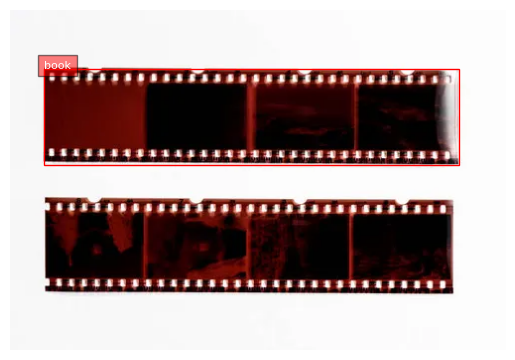

In [21]:
# Visualisation

plot_bbox(image, results['<OD>'])

## Exécution pour REGION_PROPOSAL

In [23]:
# Tâche REGION_PROPOSAL
task_region_proposal = utils.TaskType.REGION_PROPOSAL
results_region_proposal = run_example(task_region_proposal, img_path)
print(f"Results for {task_region_proposal}: {results_region_proposal}")

# Traitement des résultats
detections_region_proposal = process_region_proposal_results(results_region_proposal)

=== Generated text ===
</s><s><s><s><loc_68><loc_170><loc_903><loc_455><loc_69><loc_552><loc_894><loc_835></s>
Results for <REGION_PROPOSAL>: {'<REGION_PROPOSAL>': {'bboxes': [[34.25, 58.48149871826172, 451.75, 156.2364959716797], [34.75, 189.5074920654297, 447.25, 286.5765075683594]], 'labels': ['', '']}}
Données REGION_PROPOSAL (chaque box dans un dictionnaire séparé) :
Box_1: {'coordinates': [34.25, 58.48149871826172, 451.75, 156.2364959716797], 'label': ''}
Box_2: {'coordinates': [34.75, 189.5074920654297, 447.25, 286.5765075683594], 'label': ''}


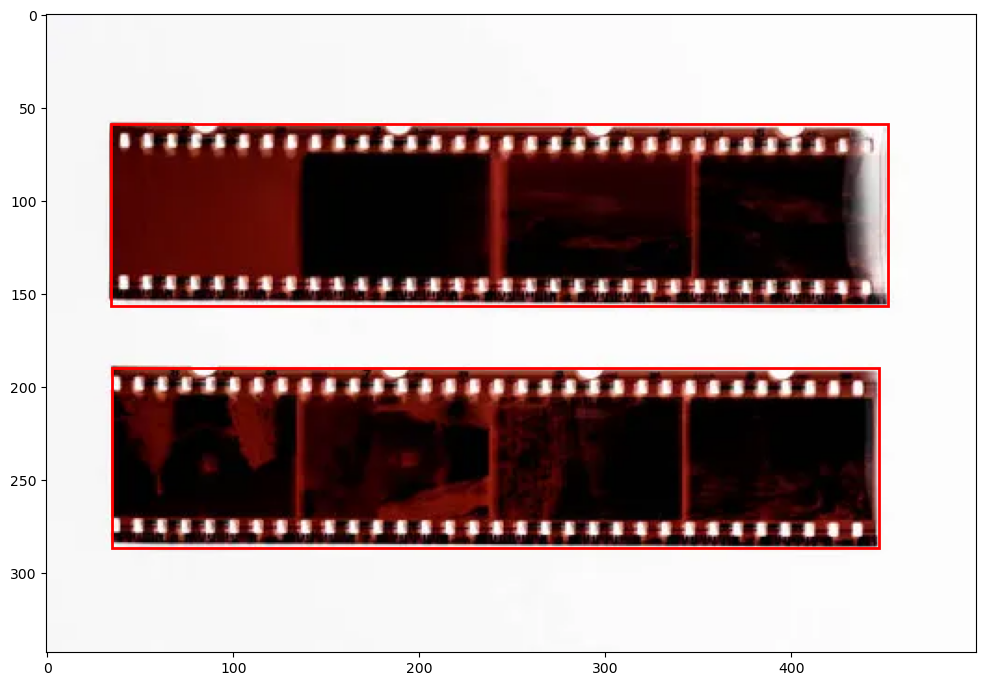

In [24]:
# Visualisation
draw_bboxes(image, detections_region_proposal)

## Exécution pour REGION_TO_SEGMENT

In [25]:
# Tâche REGION_TO_SEGMENT
task_region_to_segment = utils.TaskType.REGION_TO_SEGMENT
results_region_to_segment = run_example(task_region_to_segment, img_path)
print(f"Results for {task_region_to_segment}: {results_region_to_segment}")

# Traitement des résultats (en passant la taille de l'image pour la conversion)
image_size = (image.width, image.height)
segments_region_to_segment = process_region_to_segment_results(results_region_to_segment, image_size)

=== Generated text ===
</s><s><s><s>REGION_TO_SEGMENT><poly><loc_72><loc_787><loc_892><loc_790><loc_892><loc_831><loc_72><loc_828></poly></s>
Results for <REGION_TO_SEGMENT>: {'<REGION_TO_SEGMENT>': 'REGION_TO_SEGMENT><poly><loc_72><loc_787><loc_892><loc_790><loc_892><loc_831><loc_72><loc_828></poly>'}
Données REGION_TO_SEGMENT (chaque polygone dans un dictionnaire séparé) :
Poly_1: {'coordinates': [(36.0, 269.941), (446.0, 270.97), (446.0, 285.033), (36.0, 284.004)], 'label': 'segment'}


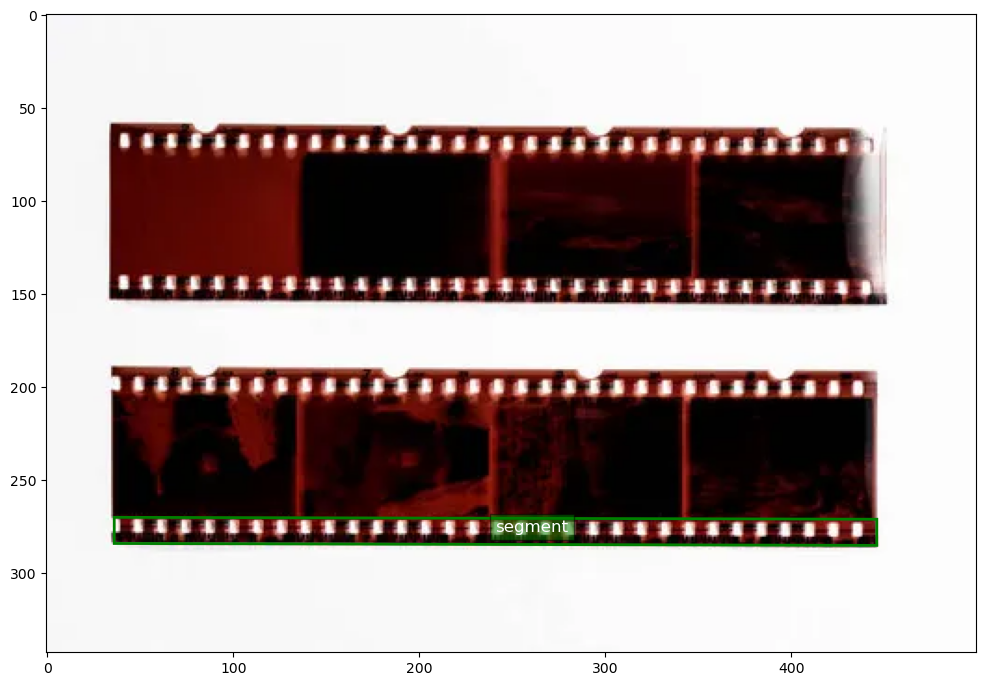

In [26]:
# Visualisation
draw_polygons(image, segments_region_to_segment)

## Exécution pour REFERRING_EXPRESSION_SEGMENTATION

In [27]:
# Charger l'image
image = Image.open(img_path).convert("RGB")
# résultat brut
raw_results = run_example(
    utils.TaskType.REFERRING_EXPRESSION_SEGMENTATION, 
    img_path, 
    text_input="unique photograph"
)

# passer dans le parser pour obtenir format uniforme
referring_data = process_referring_expression_segmentation(raw_results, image_size=(image.width, image.height), verbose=True)

# maintenant referring_data a la forme attendue

=== Generated text ===
</s><s><s><s><loc_70><loc_172><loc_156><loc_172><loc_163><loc_184><loc_167><loc_187><loc_173><loc_187><loc_177><loc_184><loc_186><loc_172><loc_364><loc_172><loc_372><loc_184><loc_375><loc_187><loc_384><loc_187><loc_387><loc_184><loc_394><loc_175><loc_580><loc_175><loc_587><loc_187><loc_591><loc_190><loc_600><loc_190><loc_604><loc_187><loc_609><loc_178><loc_784><loc_178><loc_788><loc_181><loc_793><loc_190><loc_797><loc_193><loc_804><loc_193><loc_808><loc_190><loc_815><loc_178><loc_874><loc_178><loc_877><loc_181><loc_883><loc_190><loc_888><loc_193><loc_894><loc_193><loc_897><loc_187><loc_899><loc_181><loc_901><loc_187><loc_901><loc_452><loc_700><loc_452><loc_698><loc_449><loc_461><loc_447><loc_70><loc_447><loc_67><loc_441><loc_67><loc_435></s>
Expression: N/A
Nombre de polygones: 1


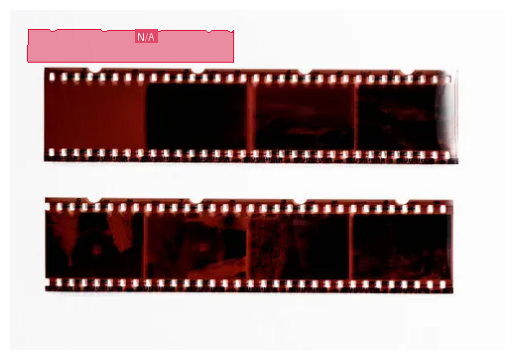

In [28]:
# Visualisation

if referring_data.get('polygons'):
    result_image = draw_referring_expression(image, referring_data)
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()
else:
    print("Aucun polygone trouvé pour la visualisation")